In [1]:
%load_ext autoreload
%autoreload 2

### imports and utilities

In [2]:
!pip install nltk scikit-learn matplotlib scipy -q

In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
from collections import Counter
from utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.special import softmax
from scipy.stats import norm
from scipy.stats import entropy as calculate_entropy

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In C:\Program Files\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Program Files\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Program Files\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


### load dataset

In [5]:
dataset = "newsgroup"

# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'alt.atheism', 'sci.space']

all_docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
all_docs, old_labels, categories = all_docs.data, all_docs.target, all_docs.target_names

In [6]:
# dataset = "bbc"

# data = pd.read_csv('bbcsport.csv')

# all_docs = data["text"].to_list()
# old_labels = data["topic"].to_list()
# categories = classes = np.unique(data["topic"]).tolist()

### clean dataset

In [7]:
datasize = 90
min_document_length = 256
max_document_length = 512


index = -1
docs, labels, label_indices = [], [], []

sizes = [0]*len(categories)

with tqdm(total=len(categories)*datasize) as pbar:
    while sum(sizes) != len(categories)*datasize:
        index += 1
        label_index = old_labels[index]
            
        if sizes[label_index] == datasize:
            continue
        
        doc = all_docs[index]
        status, doc, word_count = clean_doc(doc, True)
        
        if not status:
            continue
            
        if min_document_length is not None and len(doc) < min_document_length:
            continue
            
        if max_document_length is not None and len(doc) > max_document_length:
            continue
        
        label_indices.append(label_index)
        labels.append(categories[label_index])
        
        docs.append(doc)
        sizes[label_index] += 1
        pbar.update(1)

labels = np.array(labels)
label_indices = np.array(label_indices)

In [8]:
index = 3
print(f"Topic: {labels[index]}\n{'='*50}\n{docs[index][:512]}")

Topic: sci.space
sorry folk i should have do this and meant to just after i hit the send key orbital element of comet 1977vii from dance file p au 3 424346 e 0 151899 i 1 0988 cap omega 0 243 5652 w 0 231 1607 epoch 1977 04110 also perihelion of gehrels3 be april 1973 83 jupiter radius august 1970 3 jupiter radius hope this help i m even le of an orbital mechanic than i be an artist


In [9]:
print(sizes)
assert min(sizes) == max(sizes) == datasize

[90, 90, 90, 90]


## Split data

In [10]:
x_train, x_test, y_train, y_test = train_test_split(docs, labels, test_size =.3)

In [11]:
print(f"there are {len(docs)} total docs, {len(y_train)} train and {len(y_test)} test")

there are 360 total docs, 252 train and 108 test


### Initialize Vectorizer

In [12]:
# initialize the count vectorizer
vectorizer = CountVectorizer()

# fit it to dataset
vectorizer.fit(x_train)

vocabulary = np.array(vectorizer.get_feature_names())
print("word_count is", len(vocabulary))

word_count is 3665


### Prepare Datatset

In [13]:
# create doc count vectors
train_doc_vectors = vectorizer.transform(x_train).toarray()
test_doc_vectors = vectorizer.transform(x_test).toarray()

wdf_train = pd.DataFrame(train_doc_vectors, columns=vocabulary)
wdf_test = pd.DataFrame(test_doc_vectors, columns=vocabulary)

## Word Word Probability Distr

In [14]:
wdt_train = wdf_train.copy()
wdt_test = wdf_test.copy()

wdt_test["__labels__"] = y_test
wdt_train["__labels__"] = y_train

word_doc_count = wdf_train.sum(0)
word_word_pr_distr = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

for word in tqdm(vocabulary):
    pxy = wdf_train[wdf_train[word] > 0].sum(0) / word_doc_count[word]
#     pxy = (wdf_train.T * wdf_train[word]).sum(1)/ word_doc_count[word]
    word_word_pr_distr[word] = pxy * (word_doc_count[word] / word_doc_count)

print(f"word_word_pr_distr shape = {word_word_pr_distr.shape}")


word_word_pr_distr shape = (3665, 3665)


In [15]:
word_word_pr_distr.head()

,00,000,000mi,02,034101,04110,07,0710,0988,10,...,yourself,yuma,zeitgeist,zepher,zero,zillion,zion,zionism,zionist,zip
00,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000mi,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
034101,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [26]:
word = "space"

print(f"Topwords: Word - {word}\n{'='*50}")
word_word_pr_distr.loc[word].sort_values(ascending=False).head(10)

Topwords: Word - space


space    1.000000
be       0.896552
the      0.862069
to       0.758621
and      0.655172
have     0.620690
in       0.586207
of       0.586207
that     0.482759
it       0.482759
Name: space, dtype: float64

In [25]:
word = "space"

print(f"Topwords: Word - {word}\n{'='*50}")
word_word_pr_distr_prime.loc[word].sort_values(ascending=False).head(10)

Topwords: Word - space


dry           0.121633
awful         0.121633
clue          0.121633
zero          0.121633
technology    0.121633
crumbly       0.121633
grade         0.121633
forgotten     0.121633
crumb         0.121633
float         0.121633
Name: space, dtype: float64

In [28]:
word = "space"

print(f"Topwords: Word - {word}\n{'='*50}")
word_word_pr_distr_prime.loc[word].sort_values(ascending=False).head(10)

Topwords: Word - space


technology    0.133819
clue          0.133819
dry           0.133819
float         0.133819
zero          0.133819
grade         0.133819
crumbly       0.133819
crumb         0.133819
awful         0.133819
forgotten     0.133819
Name: space, dtype: float64

                                                  space against BASE_WORDS


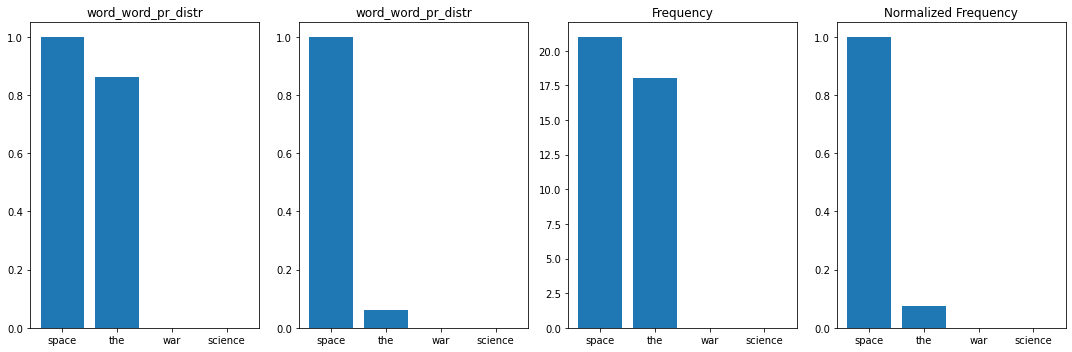

In [17]:
word = "space"
base_words = [word, "the", "war", "science"]

fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax11 = fig.add_subplot(141)
ax12 = fig.add_subplot(142)
ax13 = fig.add_subplot(143)
ax14 = fig.add_subplot(144)

print(f'{" "*50}{word} against BASE_WORDS')
ax11.set_title("word_word_pr_distr")
ax11.bar(base_words, word_word_pr_distr.loc[word][base_words])

ax12.set_title("word_word_pr_distr")
ax12.bar(base_words, word_word_pr_distr[word][base_words])

freqs, norm_freqs = [], []
wdc = (wdt_train[base_words] > 0).sum(0)
word_word_freq = (wdt_train[base_words][wdt_train[word] > 0] > 0).sum(0)

for w in base_words:
    freqs.append(word_word_freq[w])
    norm_freqs.append(word_word_freq[w] / wdc[w])

ax13.set_title("Frequency")
ax13.bar(base_words, freqs)

ax14.set_title("Normalized Frequency")
ax14.bar(base_words, norm_freqs)

plt.show()

## Trial


                                                  space against BASE_WORDS


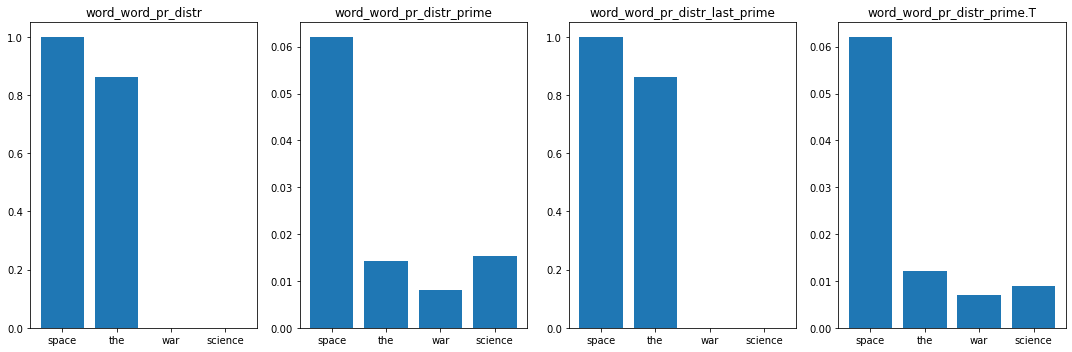

In [27]:
use_entropy = 0
num_of_iterations = 1

word_word_pr_distr_prime = word_word_pr_distr.copy()
word_word_pr_distr_prime /= word_word_pr_distr_prime.max().max()
wwx = word_word_pr_distr_prime.copy()

for n_iter in tqdm(range(num_of_iterations)):
    word_word_pr_distr_last_prime = word_word_pr_distr_prime.copy()
    word_word_pr_distr_prime = 0 * word_word_pr_distr_last_prime
    
    if n_iter >= 0:
        # the entropy and softma for reducing relation
        word_word_pr_entropy = calculate_entropy(word_word_pr_distr_last_prime, axis=1)
        word_word_pr_entropy_softmax = softmax(word_word_pr_entropy.max() - word_word_pr_entropy)
        # word_word_pr_entropy_softmax = normalize(np.reshape(word_word_pr_entropy.max() - word_word_pr_entropy, (1, -1))).flatten()
        word_word_pr_entropy_softmax = (use_entropy * word_word_pr_entropy_softmax) + int(not use_entropy)

    for word in tqdm(vocabulary):
        denom = 0
        
        indices = (wwx[word] > 0)
        xv = word_word_pr_distr_last_prime[word][indices]
        wwpes = word_word_pr_entropy_softmax[indices]

        for index, (wordx, word_pr) in enumerate(xv.iteritems()):
            gamma = word_pr * wwpes[index]
            denom += gamma
            word_word_pr_distr_prime[word] += gamma * word_word_pr_distr_last_prime[wordx]
            
        word_word_pr_distr_prime[word] /= denom
    word_word_pr_distr_prime /= word_word_pr_distr_prime.max().max()
    
    word = "space"
    base_words = [word, "the", "war", "science"]

    fig = plt.figure(figsize=(15, 5), tight_layout=True)
    ax11 = fig.add_subplot(141)
    ax12 = fig.add_subplot(142)
    ax13 = fig.add_subplot(143)
    ax14 = fig.add_subplot(144)

    print(f'{" "*50}{word} against BASE_WORDS')
    ax11.set_title("word_word_pr_distr")
    ax11.bar(base_words, word_word_pr_distr.loc[word][base_words])

    ax12.set_title("word_word_pr_distr_prime")
    ax12.bar(base_words, word_word_pr_distr_prime.loc[word][base_words])

    ax13.set_title("word_word_pr_distr_last_prime")
    ax13.bar(base_words, word_word_pr_distr_last_prime.loc[word][base_words])

    ax14.set_title("word_word_pr_distr_prime.T")
    ax14.bar(base_words, word_word_pr_distr_prime[word][base_words])

    plt.show()

## Eval Trial

In [ ]:
wdf_train_prime = 0 * wdf_train
wdf_train_last_prime = wdf_train_prime.copy()
wdf_train_last_prime /= wdf_train_last_prime.max().max()

for doc_index in tqdm(range(len(y_train))):
    denom = 0

    indices = (wdf_train.loc[doc_index] > 0)
    xv = wdf_train.loc[doc_index][indices]

    for index, (wordx, word_pr) in enumerate(xv.iteritems()):
        gamma = word_pr
        denom += gamma
        wdf_train_prime.loc[doc_index] += gamma * word_word_pr_distr_prime.loc[wordx]

    wdf_train_prime.loc[doc_index] /= denom
wdf_train_prime /= wdf_train_prime.max().max()

In [ ]:
wdf_train.loc[doc_index] * wdf_train.loc[[0, 1,2]]

In [ ]:
word = "space"
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

for doc_index in tqdm(range(len(y_train[:10]))):
    X = wdf_train.loc[doc_index] * wdf_train
    
    kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
    
    print(kmeans.labels_[doc_index], y_train[doc_index])
    print(Counter(y_train[kmeans.labels_ == 0]))
    print(Counter(y_train[kmeans.labels_ == 1]))
    print()
    
plt.show()

In [ ]:
len(kmeans.labels_)

In [ ]:
word = "space"
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

for color, category in enumerate(categories):
    xv = wdf_train_prime[word][wdf_train_prime[word] > 0][wdt_train["__labels__"] == category]
    plt.scatter(xv.index, xv.values, c=colors[color], label=category)
    plt.legend()
plt.show()

In [ ]:
wdf_train_prime.head()

### Topic Word Distr - Train Accuracy

In [ ]:
score_train = 0
for doc_index in tqdm(range(len(y_train))):
    doc_vector = wdf_train_prime.loc[doc_index]
    _, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr)
    
    mark = wdt_train.loc[doc_index]['__labels__'] == predicted_doc_topic
    score_train += mark

train_accuracy = score_train * 100 / len(y_train)
print(f"train accuracy = {train_accuracy: .2f}%")

### Topic Word Distr - Test Accuracy

In [ ]:
score_test = 0
for doc_index in tqdm(range(len(y_test))):
    doc_vector = wdf_test.loc[doc_index]
    _, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr)
    
    mark = wdt_test.loc[doc_index]['__labels__'] == predicted_doc_topic
    score_test += mark

test_accuracy = score_test * 100 / len(y_test)
print(f"test accuracy = {test_accuracy: .2f}%")

### Overrall Accuracy

In [ ]:
overall_accuracy = (train_accuracy + test_accuracy)/2
print(f"overall_accuracy = {overall_accuracy: .2f}%")